In [1]:
# Импортируем все необходимые библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

In [30]:
# Загружаем тренировочный и тестовый датасеты
train = pd.read_csv(filepath_or_buffer="train.csv")
test = pd.read_csv(filepath_or_buffer="test.csv")

In [3]:
# Посмотрим на первые 5 записей тренировочного набора
train.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender,Default
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,5,36.0,Male,0
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,5,29.0,Female,1
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaN,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,5,56.0,Female,0
3,46893387,2016-04-30,2016-03-22,NaN,NaN,NaN,NaN,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,5,27.0,Female,0
4,67128275,2016-09-19,2016-07-21,NaN,NaN,NaN,NaN,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,5,37.0,Female,0


In [4]:
# Проверим на наличие дубликатов

train_duplicates = train.duplicated().sum()
test_duplicates = test.duplicated().sum()

print(f"Train duplicated values: {train_duplicates}")
print(f"Test duplicated values: {test_duplicates}")

Train duplicated values: 0
Test duplicated values: 0


In [5]:
def missing_values_percentage(df):
    """
    Функция для расчета и вывода процента пропущенных значений в каждом столбце DataFrame.

    Параметры:
        df (pd.DataFrame): Входной DataFrame.

    Возвращает:
        None. Выводит результат в виде таблицы.
    """
    # Рассчитываем процент пропущенных значений для каждого столбца
    missing_percent = (df.isnull().mean() * 100).round(2)

    # Создаем DataFrame для удобства отображения
    missing_df = pd.DataFrame(
        {"Column": missing_percent.index, "Missing Percentage": missing_percent.values}
    )

    # Фильтруем только те столбцы, где есть пропущенные значения
    missing_df = missing_df[missing_df["Missing Percentage"] > 0]

    # Сортируем по убыванию процента пропущенных значений
    missing_df = missing_df.sort_values(by="Missing Percentage", ascending=False)

    # Выводим результат
    if missing_df.empty:
        print("В DataFrame нет пропущенных значений.")
    else:
        print(missing_df.to_string(index=False))

In [6]:
missing_values_percentage(train)

                Column  Missing Percentage
   Secret_dwarf_info_1               83.11
   Secret_dwarf_info_2               83.11
   Secret_dwarf_info_3               83.11
    First_default_date               83.11
Successful_deals_count                0.44
                Region                0.22


In [7]:
missing_values_percentage(test)

                Column  Missing Percentage
   Secret_dwarf_info_1               85.84
   Secret_dwarf_info_2               85.84
   Secret_dwarf_info_3               85.84
    First_default_date               85.84
                Region                0.40
Successful_deals_count                0.10


Тем не менее, можно заметить, что в столбцах `Secret_dwarf_info_1`, `Secret_dwarf_info_2`, `Secret_dwarf_info_3` очень мало уникальных значений, поэтому предлагаю, несмотря на то, что 85% значений в этих столбцах пропущены, заполнить их мединным значением!

Столбец `Region` можно заполнить самым частым значением, а `Successful_deals_count` заполним нулем.


In [8]:
def analyze_missing_columns(df):
    """
    Функция анализирует столбцы с пропущенными значениями:
    - Подсчитывает количество уникальных значений.
    - Строит графики распределения уникальных значений.

    Параметры:
        df (pd.DataFrame): Входной DataFrame.

    Возвращает:
        None. Выводит графики.
    """
    # Вычисляем процент пропущенных значений
    missing_percent = (df.isnull().mean() * 100).round(2)

    # Фильтруем только столбцы с пропущенными значениями
    missing_columns = missing_percent[missing_percent > 0].index

    if len(missing_columns) == 0:
        print("В DataFrame нет пропущенных значений.")
        return

    # Настройка графиков
    plt.figure(figsize=(15, 5 * len(missing_columns)))

    for i, column in enumerate(missing_columns, 1):
        # Подсчет уникальных значений
        unique_values = df[column].nunique()
        non_missing_values = df[column].dropna().value_counts()

        # График
        plt.subplot(len(missing_columns), 2, 2 * i - 1)
        sns.barplot(
            x=non_missing_values.index.astype(str),
            y=non_missing_values.values,
            palette="viridis",
        )
        plt.title(
            f"Распределение уникальных значений в '{column}'\n(Уникальных: {unique_values})",
            fontsize=12,
        )
        plt.xlabel("Значения", fontsize=10)
        plt.ylabel("Частота", fontsize=10)
        plt.xticks(rotation=45, fontsize=8)

        # Круговая диаграмма для доли пропущенных значений
        plt.subplot(len(missing_columns), 2, 2 * i)
        missing_ratio = [missing_percent[column], 100 - missing_percent[column]]
        labels = ["Пропущенные", "Не пропущенные"]
        colors = ["lightcoral", "lightgreen"]
        plt.pie(
            missing_ratio,
            labels=labels,
            autopct="%1.1f%%",
            startangle=90,
            colors=colors,
        )
        plt.title(f"Доля пропущенных значений в '{column}'", fontsize=12)

    plt.tight_layout()
    plt.show()

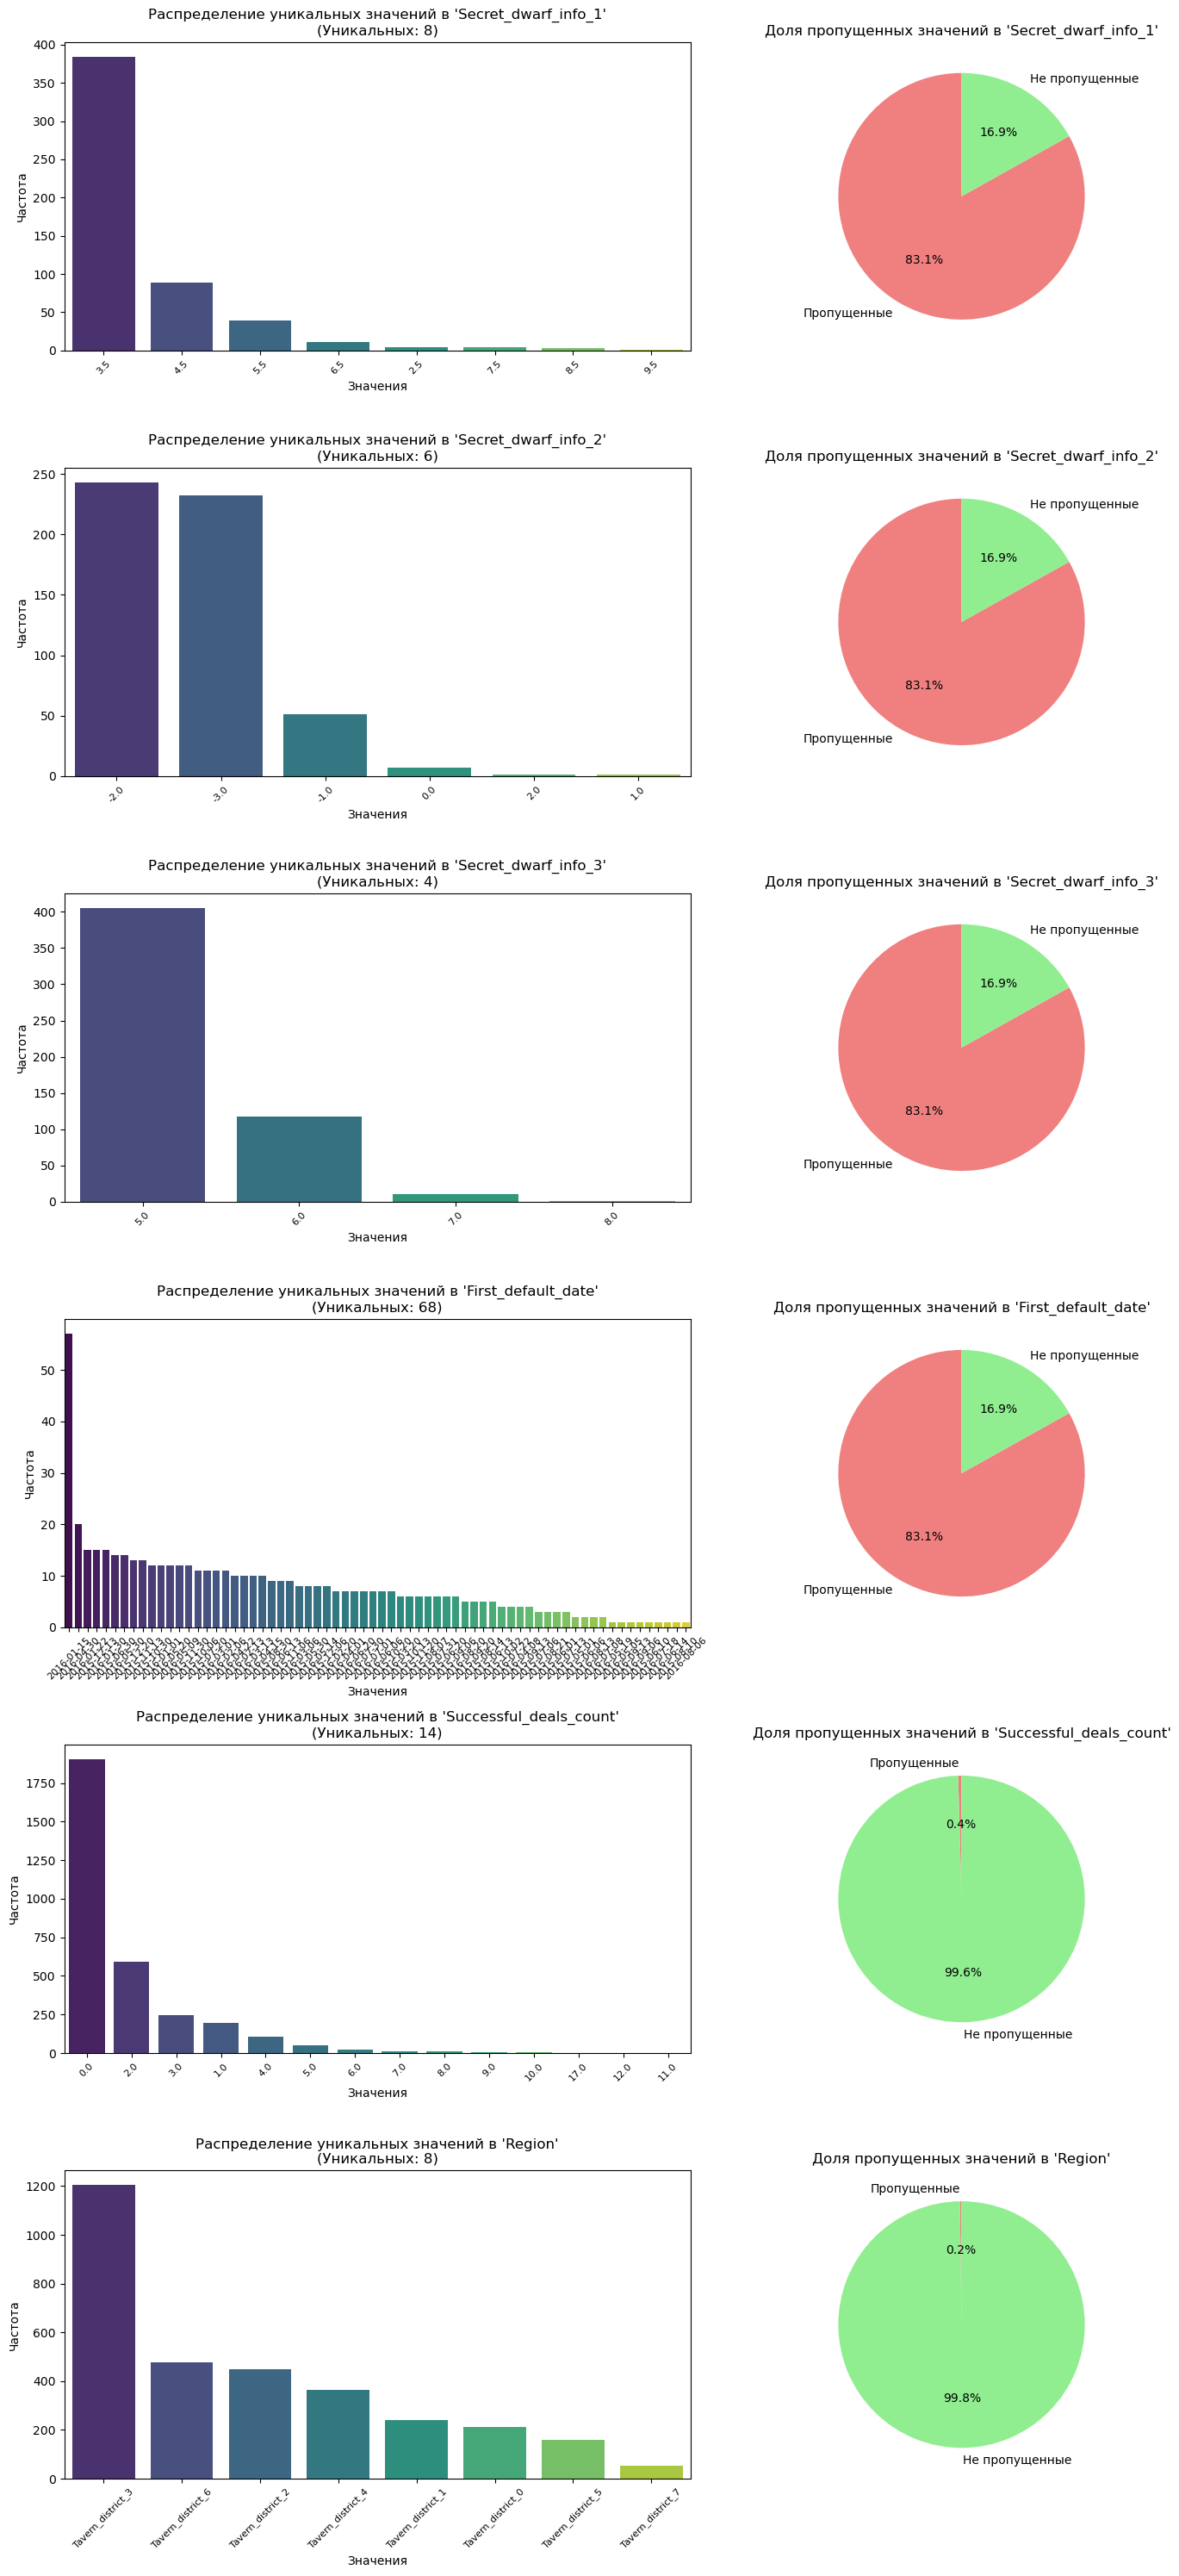

In [9]:
analyze_missing_columns(train)

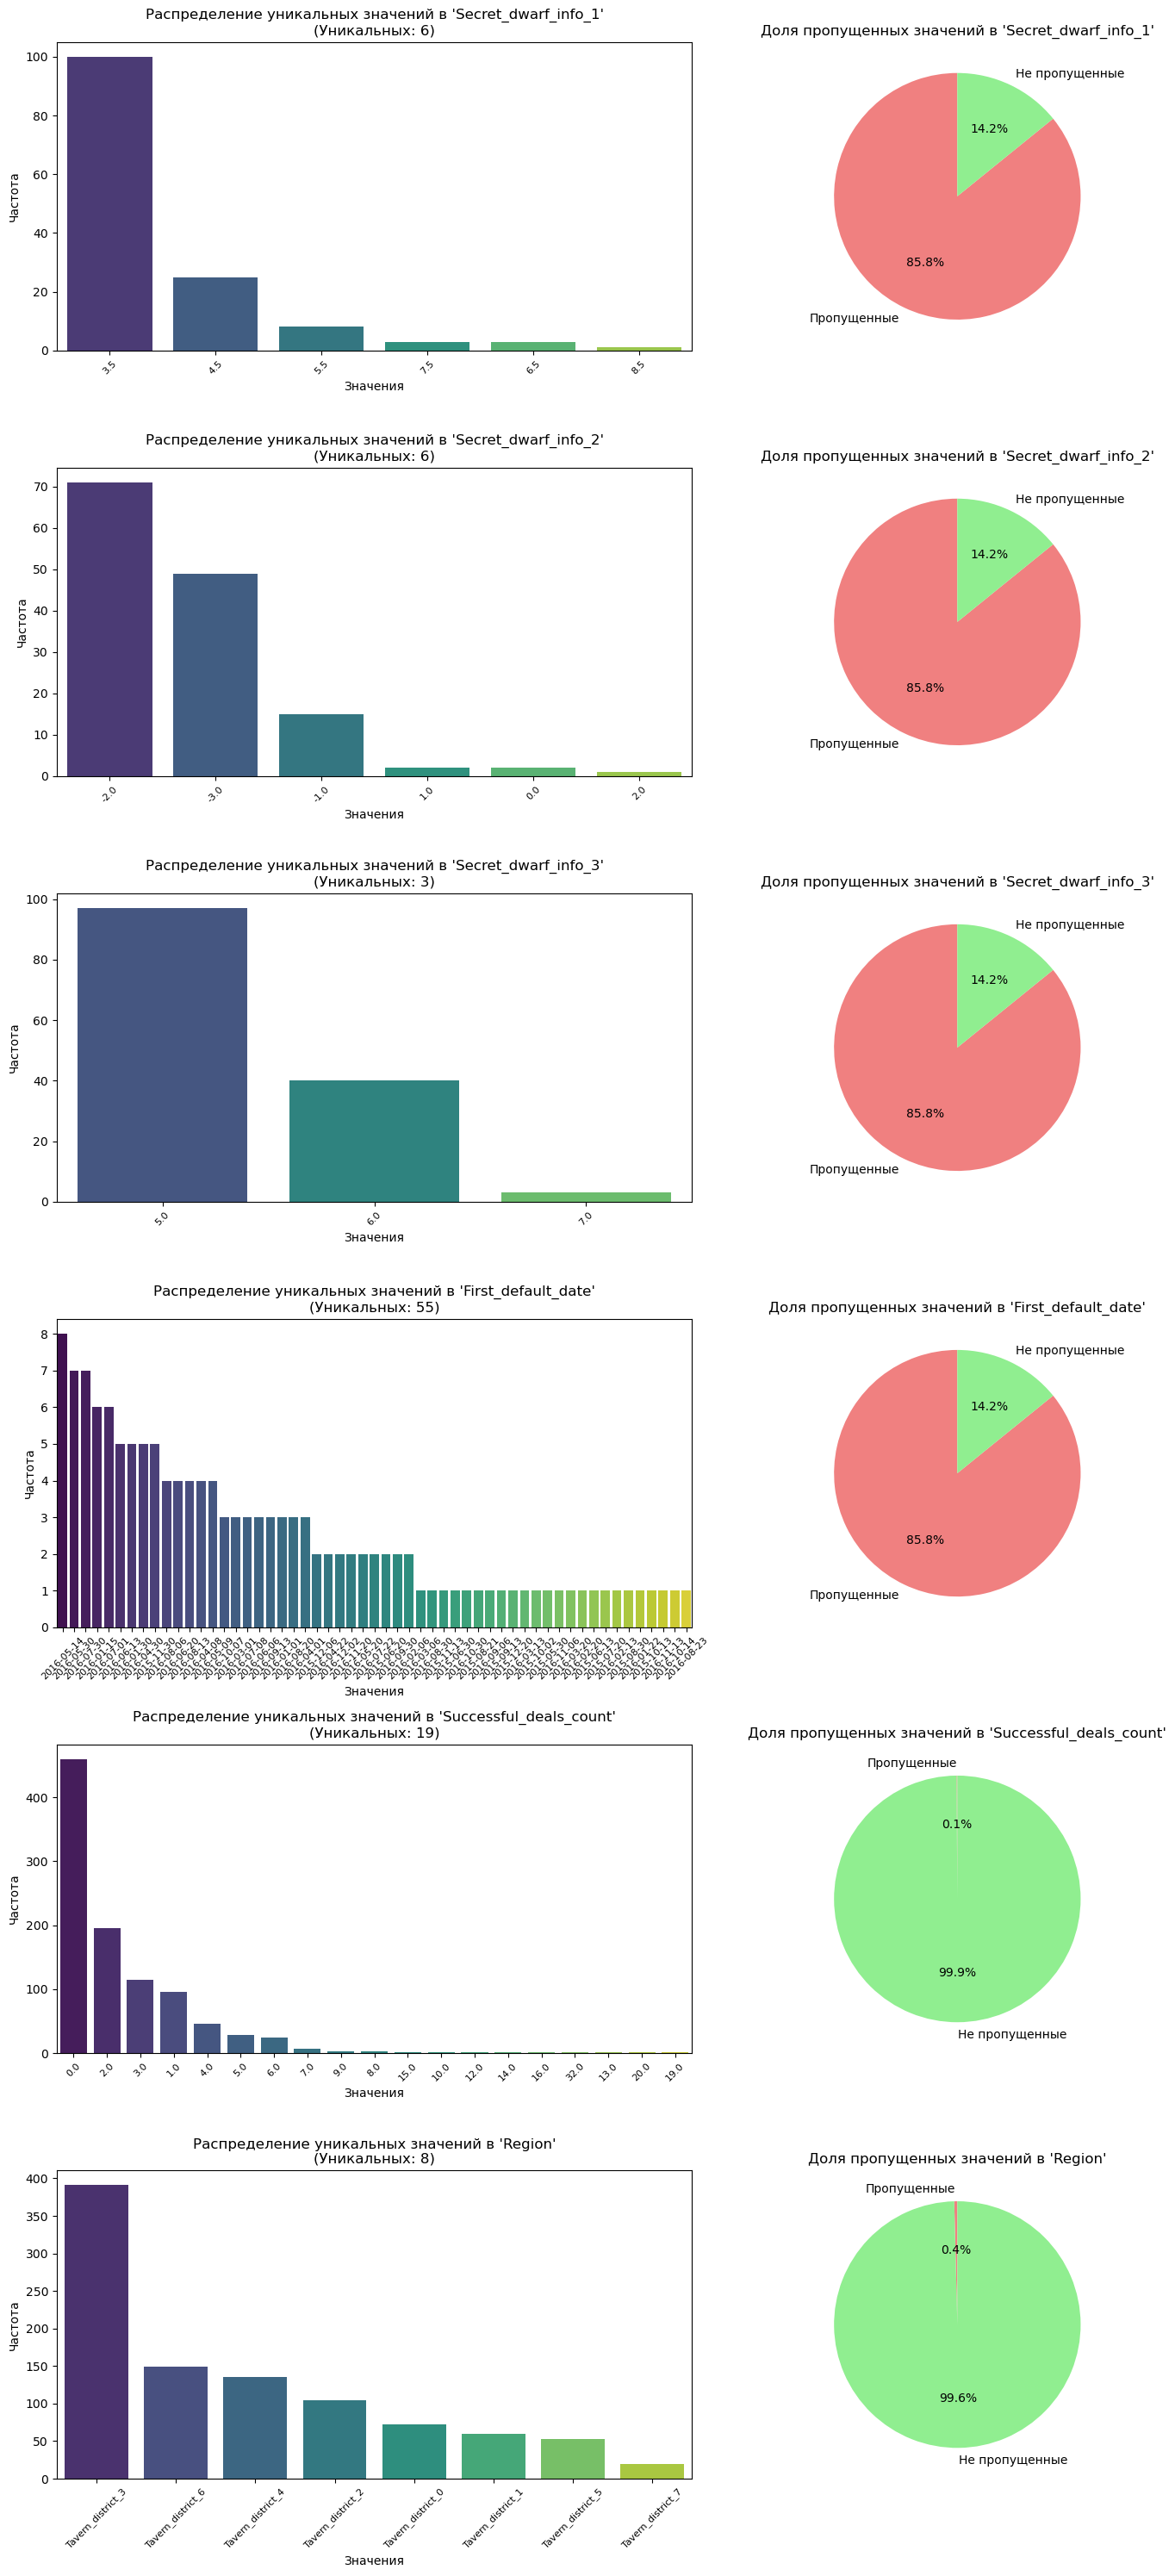

In [10]:
analyze_missing_columns(test)

In [11]:
def custom_round(x):
    """
    Args:
        x (float): Secret_dwarf_info_1 до преобразования
    Returns:
        Возвращает значение в виде: 3.5, 4.5, 5.5 (то есть оканчивается на 5 десятичных)
    """
    return (x // 0.5) * 0.5


# Словарь: какой столбец как заполнять
fill_rules = {
    "Secret_dwarf_info_1": lambda col: custom_round(col.median()),
    "Secret_dwarf_info_2": lambda col: round(col.median(), 0),
    "Secret_dwarf_info_3": lambda col: round(col.median(), 0),
    "Successful_deals_count": lambda col: 0.0,
    "Region": lambda col: col.mode()[0],
}


def fill_empty_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Заполняет пропущенные значения в DataFrame согласно правилам из fill_rules.

    Параметры:
        df (pd.DataFrame): Входной DataFrame.

    Возвращает:
        pd.DataFrame: DataFrame с заполненными пропущенными значениями.
    """
    # Проверяем, что все столбцы из fill_rules существуют в DataFrame
    missing_columns = [col for col in fill_rules if col not in df.columns]
    if missing_columns:
        raise ValueError(
            f"Следующие столбцы отсутствуют в DataFrame: {missing_columns}"
        )

    # Применяем правила для заполнения пропущенных значений
    for column, rule in fill_rules.items():
        if df[column].isnull().any():  # Проверяем, есть ли пропущенные значения
            value = rule(df[column])  # Вычисляем значение для заполнения
            df[column].fillna(value=value, inplace=True)  # Заполняем пропуски

    return df

In [12]:
train = fill_empty_columns(train)
test = fill_empty_columns(test)

### Как заполнить столбец `First_default_date`

Там где значения пустые означает, что дефолта пока что не было!
Идея как заполнить этот столбец, расположим все пустые значения где-нибудь далеко в признаковом пространстве и одинаково для всех (например: минимальная дата минус один год)


In [13]:
def process_dates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Обрабатывает даты в DataFrame:
    - Заполняет пропущенные значения в столбце "First_default_date" минимальной датой минус один год.
    - Вычисляет время до дефолта (в днях).
    - Вычисляет лаги между сделками (в днях).

    Параметры:
        df (pd.DataFrame): Входной DataFrame.

    Возвращает:
        pd.DataFrame: DataFrame с новыми вычисленными столбцами.
    """
    # Заполняем пропущенные значения в столбце "First_default_date"
    min_default_date = "2014-02-10"
    df["First_default_date"] = df["First_default_date"].fillna(value=min_default_date)

    # Вычисляем время до дефолта (в днях)
    df["Days_to_default"] = (
        pd.to_datetime(df["First_default_date"]) - pd.to_datetime(df["First_deal_date"])
    ).dt.days

    # Вычисляем лаги между сделками (в днях)
    df["Days_since_first_deal"] = (
        pd.to_datetime(df["Deal_date"]) - pd.to_datetime(df["First_deal_date"])
    ).dt.days

    return df

In [14]:
train = process_dates(train)
test = process_dates(test)

In [15]:
# Создаем объект VarianceThreshold
selector = VarianceThreshold(threshold=0.05)  # Порог для квазиконстантности

# Только number признаки
number_features = train.select_dtypes(include="number").columns

# Применяем к данным
selected_features = selector.fit_transform(train[number_features])

# Выводим результат
print(
    "Квазиконстантные признаки:",
    train[number_features].columns[~selector.get_support()].tolist(),
)

Квазиконстантные признаки: ['Hashed_deal_detail_6']


In [16]:
def drop_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(by="Deal_date", ascending=True).reset_index(drop=True)

    drop_columns = [
        "Deal_date",
        "First_deal_date",
        "First_default_date",
        "Hashed_deal_detail_6",
    ]
    df = df.drop(columns=drop_columns, axis=1).set_index("Deal_id")
    return df

In [17]:
train = drop_columns(train)
test = drop_columns(test)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    train.drop(columns=["Default"], axis=1),
    train["Default"],
    train_size=0.75,
    test_size=0.25,
    stratify=train["Default"],
)

In [21]:
object_cols = ["Gender", "Tavern", "Region"]

ohe_cols = ["Gender"]
oe_cols = [col for col in object_cols if col != "Gender"]

preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"), ohe_cols),
        (
            "ordinal",
            OrdinalEncoder(
                handle_unknown="use_encoded_value",
                unknown_value=-1,
            ),
            oe_cols,
        ),
    ],
    remainder="passthrough",
)

optimized_xgb = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            XGBClassifier(
                objective="binary:logistic",
                n_estimators=40,
                learning_rate=0.1,
                max_depth=3,
                reg_alpha=1.0,
                gamma=5,
                reg_lambda=1.0,
                subsample=0.8,
                colsample_bytree=0.8,
                use_label_encoder=False,
                eval_metric="auc",
            ),
        ),
    ]
)

# 3. Обучение с ранней остановкой
optimized_xgb.fit(
    X_train,
    y_train,
)

roc_auc_train = roc_auc_score(y_train, optimized_xgb.predict_proba(X_train)[:, 1])
roc_auc_test = roc_auc_score(y_val, optimized_xgb.predict_proba(X_val)[:, 1])
difference = roc_auc_train - roc_auc_test
# 4. Оценка качества
print(f"Train AUC: {roc_auc_train:.3f}")
print(f"Test AUC: {roc_auc_test:.3f}")
print(f"Difference between train and test: {difference:.3f}")

Train AUC: 0.799
Test AUC: 0.733
Difference between train and test: 0.066


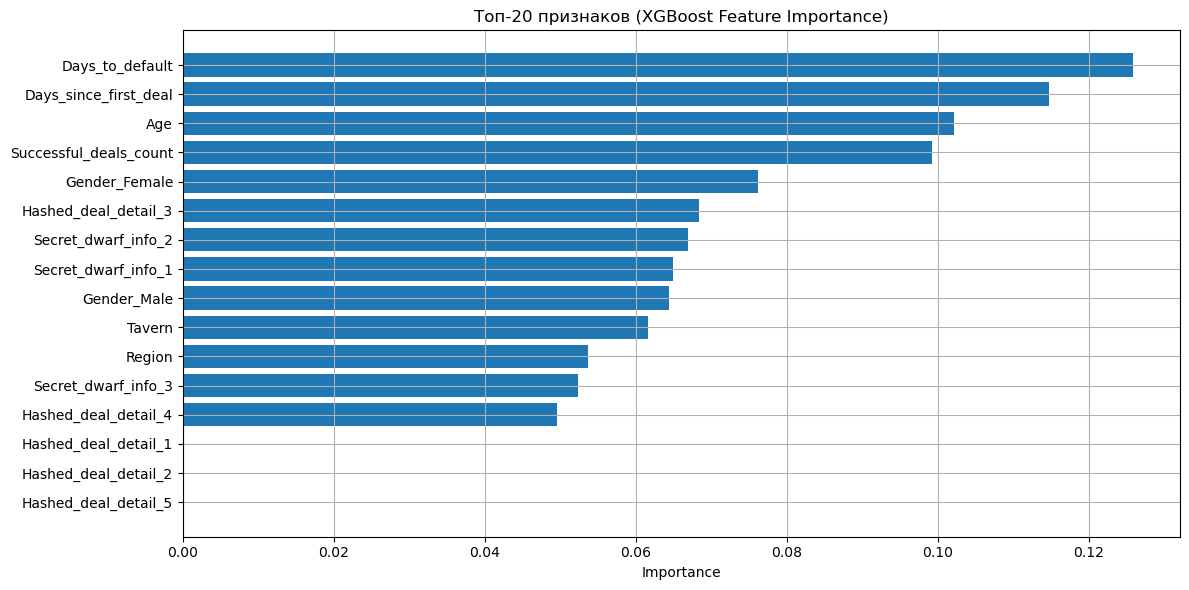

In [22]:
xgb_model = optimized_xgb.named_steps["classifier"]
preprocessor = optimized_xgb.named_steps["preprocessor"]


def get_feature_names(column_transformer):
    feature_names = []
    for name, trans, cols in column_transformer.transformers_:
        if trans == "drop" or isinstance(trans, str):
            continue

        if hasattr(trans, "get_feature_names_out"):
            try:
                names = trans.get_feature_names_out(cols)
            except:
                names = trans.get_feature_names_out()
        else:
            names = cols

        feature_names.extend(names)
    return feature_names


feature_names = get_feature_names(preprocessor)

importances = xgb_model.feature_importances_

fi_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values(
    by="importance", ascending=False
)

plt.figure(figsize=(12, 6))
plt.barh(fi_df["feature"][:20][::-1], fi_df["importance"][:20][::-1])
plt.xlabel("Importance")
plt.title("Топ-20 признаков (XGBoost Feature Importance)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Тестовые данные


In [ ]:
order = optimized_xgb.feature_names_in_
test = test[order]
test_preds = optimized_xgb.predict_proba(test)[:, 1]

In [ ]:
test.reset_index(inplace=True)

In [28]:
test["Prediction"] = test_preds
final = test[["Deal_id", "Prediction"]]
final.to_csv("prediction.csv", index=False)

In [29]:
final.head()

,Deal_id,Prediction
0,6961958,0.076755
1,69547173,0.042643
2,6979678,0.040680
3,69668061,0.062511
4,69718636,0.046920
